In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
import seaborn as sns

In [2]:
outpath = "output/visium_meta/"

In [29]:
# dataname = "V1_Mouse_Kidney"
# dataname = "V1_Mouse_Brain_Sagittal_Anterior"
# dataname = "V1_Mouse_Brain_Sagittal_Anterior_Section_2"
# dataname = "V1_Mouse_Brain_Sagittal_Posterior"
# dataname = "V1_Mouse_Brain_Sagittal_Posterior_Section_2"

# dataname = "cta_ucsf-1-5_liver"

dataname = "p20190-s003_3_BrainMetastasis"
# dataname = "p20190-s004_4_BrainMetastasis"
# dataname = "p20218-s001_L1"
# dataname = "p20218-s002_L2"
# dataname = "p20218-s003_L3"
# dataname = "p20218-s004_L4"

samples = pd.read_csv("output/make_samplesheet/spatial.csv",index_col = 0)
row = samples.loc[dataname]

cer_loc_name = row["tiss_pos_list"]
im_path = row["image"]
filt_bc_name = row["ge_mat"] + "barcodes.tsv.gz"

Image.MAX_IMAGE_PIXELS = 692696316
bound = 5
rank_quant = "_r_0.01"

# blur over spot
blurval = 70
q = 10

  
# load in tissue positions list and image

cer_loc = pd.read_csv(cer_loc_name,names = ["barcode","in_tissue","array_row","array_col","xcoord","ycoord"])
filt_bc = pd.read_csv(filt_bc_name,names=["barcode"])

# subset to only spots in the tissue (by spaceranger)
cer_loc = cer_loc[cer_loc["barcode"].isin(set(filt_bc["barcode"]))]

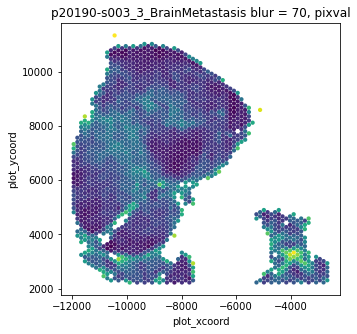

In [30]:
cer_loc["cell_id"] = dataname + "_" + cer_loc["barcode"].str.split("_").str[0].str[:-2]

# get coordinates that make image line up when plotted
cer_loc["plot_xcoord"] = cer_loc["ycoord"]
cer_loc["plot_ycoord"] = -cer_loc["xcoord"]



# load image, convert to grayscale, and blur
img = Image.open(im_path)
img = img.convert('L')
img = img.filter(ImageFilter.GaussianBlur(radius=blurval))
blur = np.array(img)

if dataname in ["p20190-s003_3_BrainMetastasis"]:
  blur = np.flip(blur.T)
  cer_loc["plot_xcoord"] = -cer_loc["xcoord"]
  cer_loc["plot_ycoord"] = cer_loc["ycoord"]

# get pixel values from the image
cer_loc["pixval"] = -1
for index, row in cer_loc.iterrows():
  cer_loc.loc[index,"pixval"] = blur[row["xcoord"],row["ycoord"]]

# plot raw pixvals
plt.figure(figsize=(5,5))
sns.scatterplot(data=cer_loc,x="plot_xcoord",y="plot_ycoord",hue="pixval",size=3,linewidth=0,palette="viridis",legend=False)
plt.title("{} blur = {}, pixval".format(dataname,blurval))
plt.savefig("{}{}_pixval.png".format(outpath,dataname))
plt.show()



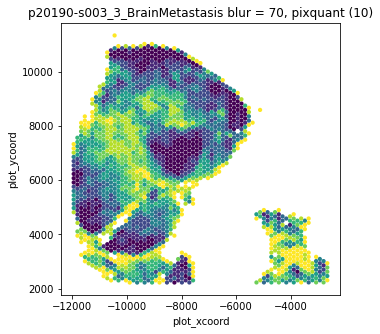

In [31]:
# quantile pixvals
temp = cer_loc.drop_duplicates("barcode")[["barcode","pixval"]]

# decrease the number of quantiles if necessary (all of the same value don't fit in a bin)
qval = q
while True:
  try:
    temp["pixquant"] = pd.qcut(temp['pixval'], qval, labels=False)
    break
  except:
    qval -= 1
    print(qval)
temp.index = temp["barcode"]
cer_loc["pixquant"] = cer_loc["barcode"].map(temp["pixquant"])

# plot quantiled pixvals
plt.figure(figsize=(5,5))
sns.scatterplot(data=cer_loc,x="plot_xcoord",y="plot_ycoord",hue="pixquant",size=3,linewidth=0,palette="viridis",legend=False)
plt.title("{} blur = {}, pixquant ({})".format(dataname,blurval,q))
plt.savefig("{}{}_pixquant.png".format(outpath,dataname))

plt.show()
img.save("{}{}_blur.png".format(outpath,dataname))
img.show()

In [32]:

# save new file
cer_loc.to_csv("{}meta_{}.tsv".format(outpath,dataname),sep="\t",index=False)
print("{}meta_{}.tsv".format(outpath,dataname))

# for ReadZS we can't include hyphen in cell ids
if "-" in dataname:
  cer_loc["cell_id"] = cer_loc["cell_id"].replace("-","_") 
  cer_loc.to_csv("{}meta_{}.tsv".format(outpath,dataname.replace("-","_")),sep="\t",index=False)
  print("{}meta_{}.tsv".format(outpath,dataname.replace("-","_")))

output/visium_meta/meta_p20190-s003_3_BrainMetastasis.tsv
output/visium_meta/meta_p20190_s003_3_BrainMetastasis.tsv
